# Малютин Павел, ИТПЗ РАН
 

In [4]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [12]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('./catalogues/input (1).csv',sep=';')
#my_cat.mag = round(my_cat.mag, 1)  
my_cat

,year,time,latitude,longitude,depth,mag,a,b,c,d,e,f
0,2007,1.170732,-21.126,-68.510,138.3,3.6,2007,1,2,5,48,36
1,2007,2.193046,-19.832,-69.008,107.7,3.8,2007,1,3,6,20,44
2,2007,2.952705,-22.361,-70.381,63.2,4.4,2007,1,4,0,34,39
3,2007,3.049925,-19.485,-69.429,103.6,4.7,2007,1,4,2,54,39
4,2007,3.235599,-20.217,-69.182,98.0,3.6,2007,1,4,7,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10313,2014,2951.533076,-24.195,-67.256,193.1,4.0,2014,12,30,14,30,23
10314,2014,2951.588941,-22.610,-70.344,39.0,4.3,2014,12,30,15,50,50
10315,2014,2951.845424,-20.351,-68.942,117.3,3.5,2014,12,30,22,0,10
10316,2014,2952.150410,-19.158,-69.171,123.0,4.7,2014,12,31,5,19,21


Text(0.5, 0.98, 'График повторяемости землетрясений')

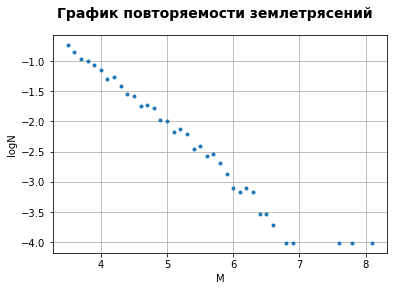

In [13]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
 # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv


### Необходимо выбрать представительную магнитуду

In [14]:
M_0 = float(input())
b_value = 1 / (my_cat['mag'].mean() - M_0) * (1/ math.log(10))
# расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv
print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))

3.5
b-value is: 0.9428629517060932  ±  0.009282197598427008


# Fractal dimension
#### но, прежде всего, функция вычисления расстояния между землетрясениями


In [15]:
global Pi2, RAD, FLAT
Pi2 = math.pi/2 # тупо пи-на-два
RAD = 0.01745329 # DGR -> RAD
FLAT = 0.993231 # поправка на эллипсоидноть

In [16]:
#@njit
def eq_dist (fi1, la1, fi2, la2, d1, d2): # fi - широта (latitude), la - долгота (longtitude)
    '''Функция позволяет вычислять расстояение между двумя точками земли с учетом сплюсности и глубины'''    
    #if ((fi1-fi2)==0 and (la1-la2)==0): #проверка на расстояние между одним и тем же землетрясением
    #    return (0.0)  
    col1 = Pi2 - math.atan(FLAT * math.tan(fi1 * RAD))
    col2 = Pi2 - math.atan(FLAT * math.tan(fi2 * RAD))
    
    dlon =  la2 * RAD - la1 * RAD
    
    cosdel = math.sin(col1) * math.sin (col2) * math.cos(dlon) + math.cos(col1) * math.cos(col2)
    delr = math.acos(cosdel)
    colat = Pi2 - (fi1 * RAD + fi2 * RAD) / 2.0
    distan_eq =  math.sqrt((delr * 6371.227 * (1.0 + 0.00337853 * (1./3. -((math.cos(colat))*math.cos(colat)))))**2 + (d2-d1)**2)
    if distan_eq == 0:
        distan_eq = 0.01
    return distan_eq

## Непосредственный расчёт фрактальной размерности

In [17]:
'''создание numpy-array для более быстрого обращения [к памяти]
в цикле к соответствующим значениям широты и долготы'''
latitude = my_cat.latitude.to_numpy()
longitude = my_cat.longitude.to_numpy()
depth = my_cat.depth.to_numpy()

In [18]:
'''Вместо того, чтобы каждый раз перебирать для каждого заданного расстояния между
землетрясениями все возможные пары расстояний, в самом начале создается массив
с этими парами. Это существенно сокращает время выполнения программы'''

array_of_dist = [[0] * N_tot[0] for i in range(N_tot[0])]

for i in tqdm(range((N_tot[0]))):
    for j in range(i+1, N_tot[0]):
        #array_of_dist.append(eq_dist(latitude[k], longitude[k], latitude[j], longitude[j], depth[k], depth[j]))
        array_of_dist[i][j] = eq_dist(latitude[i], longitude[i], latitude[j], longitude[j], depth[i], depth[j])
        array_of_dist[j][i] = array_of_dist[i][j]

100%|████████████████████████████████████| 10318/10318 [07:48<00:00, 22.01it/s]


In [20]:
array_of_dist[:][2]

[248.5983321812442,
 317.37868667978995,
 0,
 335.8923805850982,
 270.2577013705546,
 206.8897361236186,
 228.65325557275605,
 278.44754963016527,
 277.0153750357854,
 248.24665076441718,
 195.9714716810259,
 346.615033561757,
 216.0793358050873,
 286.6222084967784,
 218.93254619846547,
 211.27133134605978,
 239.70878725565126,
 242.9925104270452,
 268.95875976263915,
 202.05959566550774,
 229.57541768210763,
 219.0099346534797,
 179.12738462390865,
 81.74502077623009,
 183.04864906622177,
 252.98447995160217,
 295.56090370151765,
 373.5165850698149,
 176.9181977078727,
 171.81592264721482,
 272.27725702694215,
 173.44994372078148,
 289.217118709004,
 330.58153942786794,
 214.97175302162458,
 232.67158911886284,
 227.16417630319836,
 221.5589533823399,
 210.52877391577573,
 246.99776526905924,
 220.2715706117232,
 243.9423810303968,
 279.9106563172428,
 319.5631393599905,
 413.6350520436328,
 161.77839890590607,
 234.33686521837316,
 288.36276532961676,
 188.59950713260508,
 212.503897

In [21]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(1,200,50) #задает равномерно распределенный массив возможных расстояний м/у ЗТ
element_count = 0
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):  
    for n in range(N_tot[0]):
        for m in range(n+1, N_tot[0]):
            if array_of_dist[n][m] < i:
                element_count += 1
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    element_count = 0
    #объединение старого массива для расчета FD и новых данных с lg(N/N_0) и lg(A)

100%|██████████████████████████████████████████| 50/50 [14:21<00:00, 17.22s/it]


Float64Index([               0.0, 0.7042556007977027, 0.9601114431034229,
              1.1200364379665704, 1.2366606289211788, 1.3285044186377297,
              1.4042750486131312, 1.4687691803548966, 1.5249125010245796,
              1.5746217429810228, 1.6192211457496264, 1.6596640021638176,
              1.6966594491562106, 1.7307493258934585, 1.7623569832004118,
               1.791819496422198, 1.8194096245830425, 1.8453511991481542,
              1.8698301688843786,  1.893002693940109, 1.9150011873598642,
               1.935938898606875, 1.9559134419503343,  1.975009548406087,
              1.9933012376512977,  2.010853550700626,   2.02772394580848,
               2.043963433215953, 2.0596175052644243, 2.0747269046213748,
              2.0893282632962764, 2.1034546376786594, 2.1171359592626766,
              2.1303994165159765, 2.1432697801421785, 2.1557696815169702,
              2.1679198521615524,  2.179739330618346, 2.1912456419128796,
              2.2024549538487865,  2.2

Text(0, 0.5, 'log(N/N_0)')

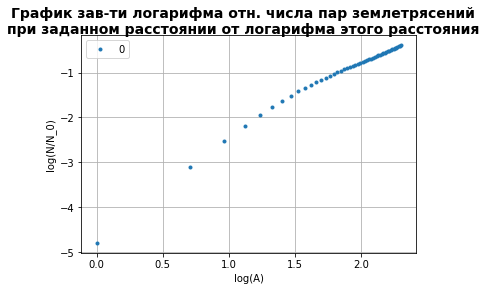

In [22]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

Text(0, 0.5, 'log(N/N_0)')

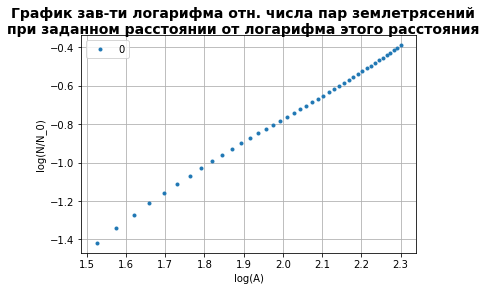

In [26]:
fractalka.drop(fractalka[fractalka.index < 1.5].index, inplace=True)
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

In [28]:
X = fractalka.index.to_numpy().reshape(-1, 1)
Y = fractalka[0].to_numpy().reshape(-1, 1)
linear_model_d = LinearRegression()
linear_model_d.fit(X, Y)
d_f = linear_model_d.coef_[0][0] # фрактальная размерность
print('\033[1m' + 'Fractal dimension is', d_f)

Fractal dimension is 1.273438905462421


# Функция близости

In [29]:
print("b-value is               ", round(b_value,3))
print("d_f is                   ", round(d_f,3))
print("Minimal magnitude M_0 is ", M_0)

b-value is                0.943
d_f is                    1.273
Minimal magnitude M_0 is  3.5


In [30]:
n_ = [[0] * N_tot[0] for i in range(N_tot[0])]
T_ = [[0] * N_tot[0] for i in range(N_tot[0])]

### Функция для рассчёта времени между зт

In [50]:
import time
import datetime
import copy
t = copy.deepcopy(my_cat.time.to_numpy())
for i in range(len(t)):
    t[i] = t[i].replace('T','')
    t[i] = t[i][:-5]
for i in tqdm(range(N_tot[0]-1,-1,-1)):
    for j in range(i,-1,-1):
        ti_i = time.strptime(t[i], "%Y-%m-%d%H:%M:%S")
        ti_j = time.strptime(t[j], "%Y-%m-%d%H:%M:%S")
        t_i = datetime.datetime(ti_i.tm_year, ti_i.tm_mon, ti_i.tm_mday, ti_i.tm_hour, ti_i.tm_min, ti_i.tm_sec)
        t_j = datetime.datetime(ti_j.tm_year, ti_j.tm_mon, ti_j.tm_mday, ti_j.tm_hour, ti_j.tm_min, ti_j.tm_sec)
        T_[i][j] = (t_j - t_i).total_seconds()
        T_[j][i] = T_[i][j]


100%|██████████████████████████████████████| 1323/1323 [00:45<00:00, 28.94it/s]


In [64]:
for i in tqdm(range(N_tot[0])):
    for j in range(i,N_tot[0]): #ВНИМАНИЕ - ХЗ ПОЧЕМУ ОТ И БЕРУ. ХОЧУ ПРОВЕРИТЬ
        if i == j:
            n_[i][j] = 10000000000
            n_[j][i] = 10000000000
            continue 
        n_[i][j] = T_[i][j]*(array_of_dist[i][j]**d_f)*(10**((-b_value)*my_cat.mag[i]))
        n_[j][i] = n_[i][j]

100%|██████████████████████████████████████| 1323/1323 [00:17<00:00, 76.94it/s]


In [65]:
N = [0] * N_tot[0]
D = [0] * N_tot[0]
for i in range(len(n_)):
    D[i] = round(math.log10((min(n_[i][:]))),1)
    N[i] = n_[:][i].index(min(n_[i][:]))
resultate = pd.DataFrame({'Closest_neigh':D, 'Index_o_CN':N})

In [66]:
Dist_to_Nearest = resultate.Closest_neigh.value_counts(normalize=True)
from pathlib import Path  
filepath = Path('./results/nearest_dist.csv')
Dist_to_Nearest.to_csv(filepath)